[*********************100%%**********************]  1 of 1 completed


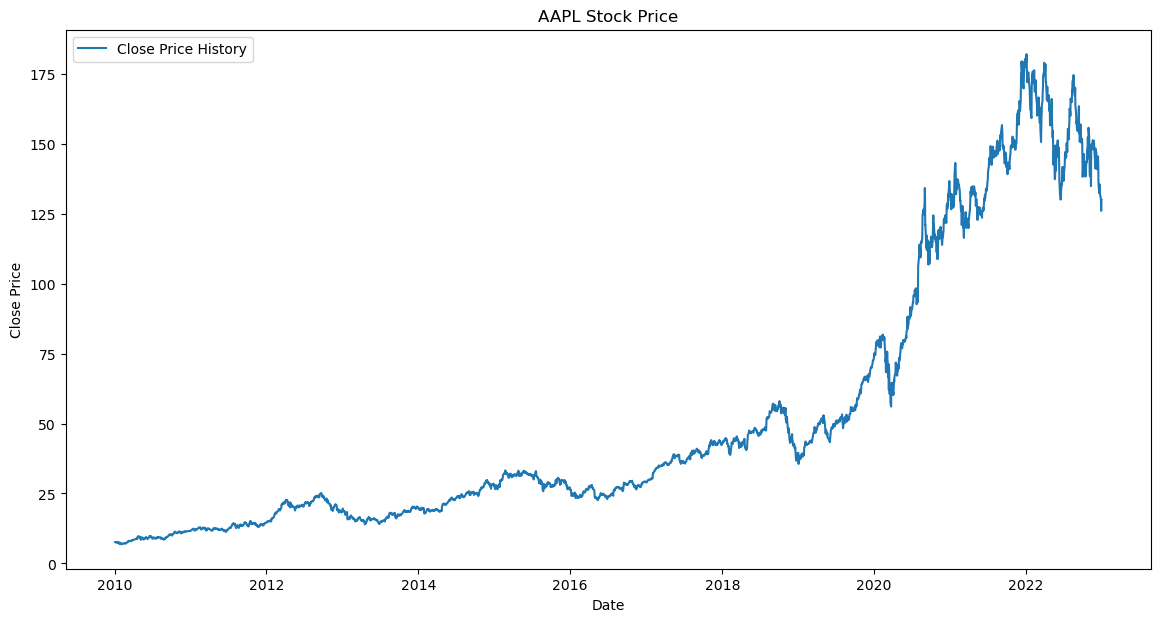

C:\Users\tm149\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2558/2558 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 4.3984e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


C:\Users\tm149\AppData\Local\Temp\ipykernel_4056\4071374974.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


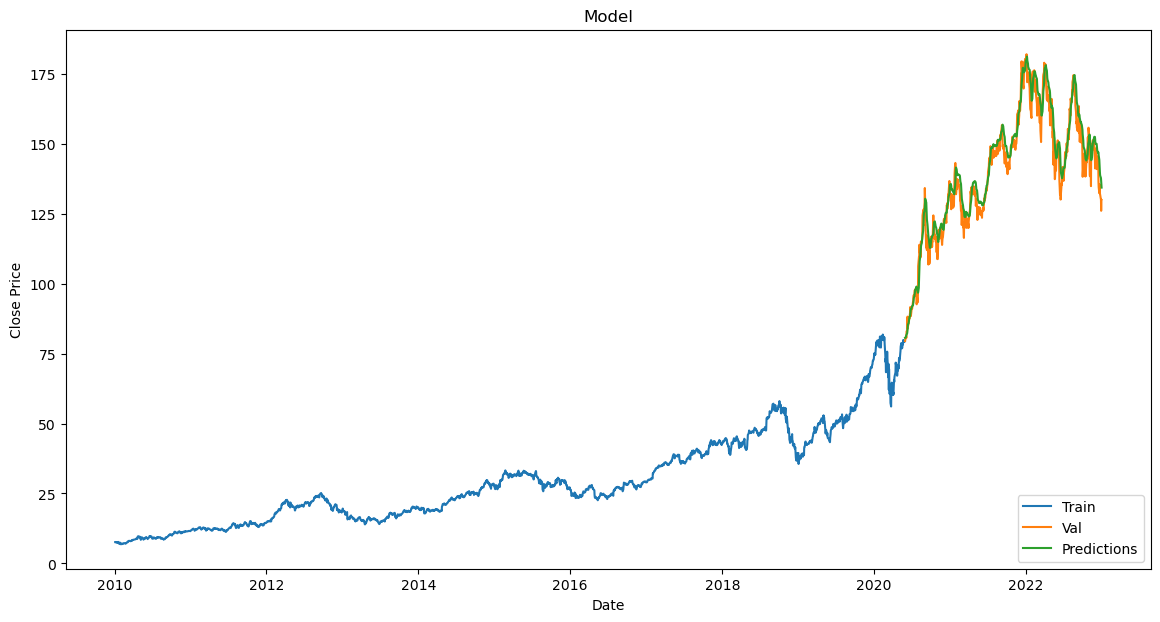

,Close,Predictions
Date,,
2022-12-23,131.860001,138.686005
2022-12-27,130.029999,137.744843
2022-12-28,126.040001,136.721924
2022-12-29,129.610001,135.259109
2022-12-30,129.929993,134.335876


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load stock price data
ticker = 'AAPL'  # You can change this to any stock ticker you want
stock_data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

# Display the first few rows of the dataset
stock_data.head()

# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price History')
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Prepare the data
# Use only the 'Close' column for prediction
data = stock_data.filter(['Close'])
dataset = data.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Define the training data size (80% of the dataset)
training_data_len = int(np.ceil(len(dataset) * 0.8))

# Create the training data
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data to be 3D (samples, timesteps, features) for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create the testing data
# Create a new array containing scaled values from index training_data_len-60 to the end
test_data = scaled_data[training_data_len - 60:, :]

# Create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert x_test to a numpy array
x_test = np.array(x_test)

# Reshape the data to be 3D for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the predictions
plt.figure(figsize=(14, 7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Display the valid and predicted prices
valid.tail()
